# HARPE(T) Dataset Exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import torch.utils.data as data
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms
import cv2 as cv
from PIL import Image

In [2]:
class H5Dataset(data.Dataset):

    def __init__(self, file_path):
        super(H5Dataset, self).__init__()
        h5_file = h5py.File(file_path + ".h5", 'r')
        # Extract filenames
        # TODO: filter filenames based on action
        path = "/".join(file_path.split('/')[:-1])
        path += "/images_" + file_path.split("_")[-1] + "/"
        filenames = h5_file.get('imgname')
        shape = filenames.shape
        filenames = np.array([chr(letter) for item in filenames for letter in item.astype(int)])
        self.data = np.array([np.array(Image.open(path + "".join(fname)).resize((224, 224))) for fname in filenames.reshape(shape)])
        self.target = h5_file.get('part')
        
    def __getitem__(self, index):
        return (torch.from_numpy(self.data[index,:,:,:]).float(),
               torch.from_numpy(self.target[index,:,:,:]).float())
    
    def __len__(self):
        return self.data.shape[0]

In [3]:
path = "../../../datasets/VIP-HARPET/annot_"
Htest = H5Dataset(path + "test")
Htrain = H5Dataset(path + "train")
Hvalid = H5Dataset(path + "valid")

In [4]:
# Joint ordering: 18 joints total (including stick)
#
N = 18
pairs = [[0, 1],
         [1, 2],
         [2, 6],
         [3, 4],
         [3, 6],
         [4, 5],
         [6, 8],
         [8, 9],
         [12, 8],
         [10, 11],
         [11, 12],
         [10, 16],
         [16, 17],
         [13, 8],
         [13, 14],
         [14, 15]]

## NVIDIA trt_pose

In [5]:
from PIL import Image
import torch2trt
from torch2trt import TRTModule
from trt_pose import coco, models
from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects
from jetcam.usb_camera import USBCamera
from jetcam.utils import bgr8_to_jpeg
import ipywidgets
from IPython.display import display
import freenect
import json
import time
import signal
import sys

In [6]:
MODEL_WEIGHTS = 'resnet18_baseline_att_224x224_A_epoch_249.pth'
OPTIMIZED_MODEL = 'resnet18_baseline_att_224x224_A_epoch_249_trt.pth'
WIDTH = 224
HEIGHT = 224

In [7]:
mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')

image_w = ipywidgets.Image(format='jpeg')

In [8]:
# libfreenect capture functions
def get_video():
    array,_ = freenect.sync_get_video()
    array = cv2.cvtColor(array,cv2.COLOR_RGB2BGR)
    return array

def get_depth():
    array,_ = freenect.sync_get_depth()
    array = array.astype(np.uint8)
    return array

def benchmark(frame_count=50.0):
    # Return FPS for current model
    t0 = time.time()
    torch.cuda.current_stream().synchronize()
    for i in range(frame_count):
        y = model_trt(data)
    torch.cuda.current_stream().synchronize()
    t1 = time.time()
    return frame_count / (t1 - t0)

def preprocess(image):
    global device
    device = torch.device('cuda')
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

def execute(image):
#     image = change['new']
    data = preprocess(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    draw_objects(image, counts, objects, peaks)
    image_w.value = bgr8_to_jpeg(image[:, ::-1, :])

In [9]:
with open('human_pose.json', 'r') as f:
    human_pose = json.load(f)

In [10]:
%pprint

Pretty printing has been turned OFF


In [11]:
#TODO:
# - use 'nose' marker as 'head' marker
# - remove face markers from skeleton: 'left_eye', 'right_eye', 'left_ear', 'right_ear', ('neck')
human_pose

{'supercategory': 'person', 'id': 1, 'name': 'person', 'keypoints': ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle', 'neck'], 'skeleton': [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [18, 1], [18, 6], [18, 7], [18, 12], [18, 13]]}

In [12]:
topology = coco.coco_category_to_topology(human_pose)
num_parts = len(human_pose['keypoints'])
num_links = len(human_pose['skeleton'])

# Load model
# TODO: extend model to include additional joints
model = models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()
model.load_state_dict(torch.load(MODEL_WEIGHTS))

<All keys matched successfully>

In [13]:
# Optimization with tensorRT
# NOTE: optimization is device specific
data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()
model_trt = torch2trt.torch2trt(model, [data], fp16_mode=True, max_workspace_size=1<<25)
# torch.save(model_trt.state_dict(), OPTIMIZED_MODEL)

In [14]:
# Load optimized model
model_trt = TRTModule()
model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))
parse_objects = ParseObjects(topology)
draw_objects = DrawObjects(topology)

In [15]:
# TEST W/ WEBCAM:
# camera = USBCamera(width=WIDTH, height=HEIGHT, capture_fps=30)
# camera.running = True
# execute({'new': camera.value})
# cap = cv.VideoCapture(0)
image_w = ipywidgets.Image(format='jpeg')

In [16]:
# camera.cap.release()

In [17]:
def execute(change):
    image = change['new']
    data = preprocess(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    draw_objects(image, counts, objects, peaks)
    image_w.value = bgr8_to_jpeg(image)
    return image

In [18]:
display(image_w)

Image(value=b'', format='jpeg')

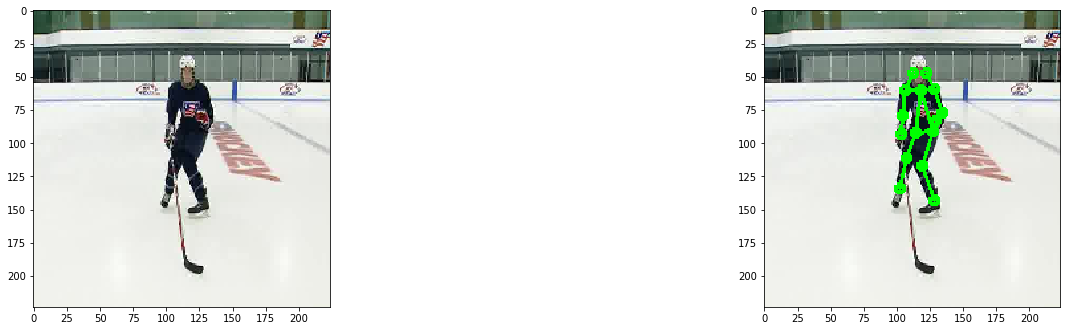

In [19]:
# Results
# Check training data
img, skeleton = Htrain.data[21], Htrain.target[21]
skeleton = np.rint(skeleton).astype(int)
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
# img2 = img.copy()
# Draw joints
# for joint in skeleton:
#     img2 = cv.circle(img2, (joint[0], joint[1]), 5, (0, 100, 255), thickness=-1, lineType=cv.FILLED)
# Connect joints
# for link in pairs:
#     A = link[0]
#     B = link[1]
#     img2 = cv.line(img2, tuple(skeleton[A]), tuple(skeleton[B]), (0, 255, 0), 3)

# ax2 = fig.add_subplot(2,2,2)
# ax2.imshow(img2)

# Show results of trt-pose
res = execute({'new': img.copy()})
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(res)

In [20]:
# camera.unobserve_all()